<a href="https://colab.research.google.com/github/riponalmamun/x-ray-dataset/blob/main/x_ray_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Dataset paths
dataset_path = "/content/drive/MyDrive/x ray dataset"
healthy_path = os.path.join(dataset_path, "Healthy")
disease_path = os.path.join(dataset_path, "disease")

# Image size for resizing
IMG_SIZE = (128, 128)

# Preprocessing function
def preprocess_images(healthy_path, disease_path, img_size=IMG_SIZE):
    X, y = [], []
    class_labels = {"Healthy": 0, "Disease": 1}  # Assigning numerical labels

    # Load healthy images
    for img_name in os.listdir(healthy_path):
        img_path = os.path.join(healthy_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, img_size)
        X.append(img)
        y.append(class_labels["Healthy"])

    # Load diseased images
    for img_name in os.listdir(disease_path):
        img_path = os.path.join(disease_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, img_size)
        X.append(img)
        y.append(class_labels["Disease"])

    X = np.array(X) / 255.0  # Normalize pixel values to [0, 1]
    y = np.array(y)
    return X, y

# Preprocess the images
X, y = preprocess_images(healthy_path, disease_path)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Check dataset shapes
print(f"Training Data Shape: {X_train.shape}, Labels Shape: {y_train.shape}")
print(f"Testing Data Shape: {X_test.shape}, Labels Shape: {y_test.shape}")


Training Data Shape: (636, 128, 128), Labels Shape: (636,)
Testing Data Shape: (160, 128, 128), Labels Shape: (160,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Reshape data to include channel dimension
X_train = X_train[..., np.newaxis]  # Shape: (num_samples, 128, 128, 1)
X_test = X_test[..., np.newaxis]

# CNN Model Definition
def create_cnn_model(input_shape=(128, 128, 1)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')  # Binary classification (Healthy/Disease)
    ])
    return model

# Create the model
model = create_cnn_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,391,873 (28.20 MB)

 Trainable params: 7,391,873 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,  # Training data
    validation_split=0.2,  # Use 20% of the training data for validation
    epochs=20,  # Number of epochs
    batch_size=32,  # Batch size
    verbose=1  # Show progress during training
)


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 859ms/step - accuracy: 0.6416 - loss: 1.6970 - val_accuracy: 0.7500 - val_loss: 0.6213
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7702 - loss: 0.5637 - val_accuracy: 0.7500 - val_loss: 0.6155
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7627 - loss: 0.5765 - val_accuracy: 0.7500 - val_loss: 0.5978
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 989ms/step - accuracy: 0.7538 - loss: 0.5762 - val_accuracy: 0.7500 - val_loss: 0.6059
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 759ms/step - accuracy: 0.7695 - loss: 0.5509 - val_accuracy: 0.7500 - val_loss: 0.5871
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 831ms/step - accuracy: 0.7766 - loss: 0.5284 - val_accuracy: 0.7500 - val_loss: 0.6029
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 898ms/step - accuracy: 0.7635 - loss: 0.5323 - val_accuracy: 0.7656 - val_loss: 0.5993
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 874ms/step - accuracy: 0.7750 - loss: 0.5233 - val_accuracy: 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.6898 - loss: 0.6757
Test Accuracy: 0.64


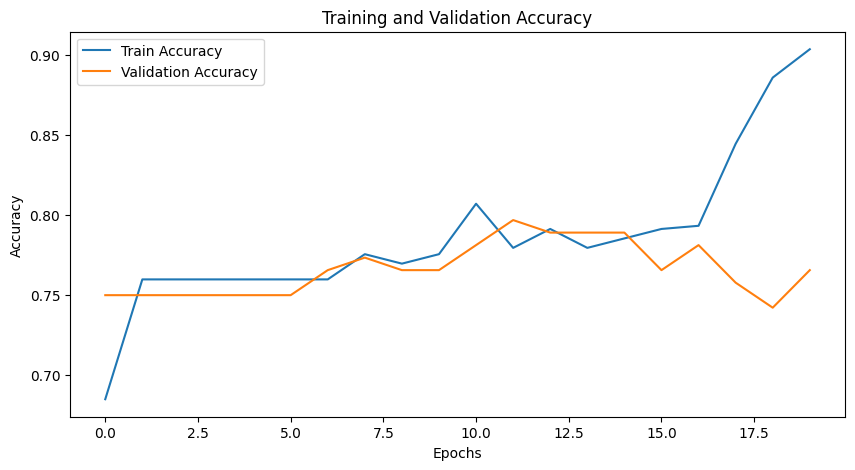

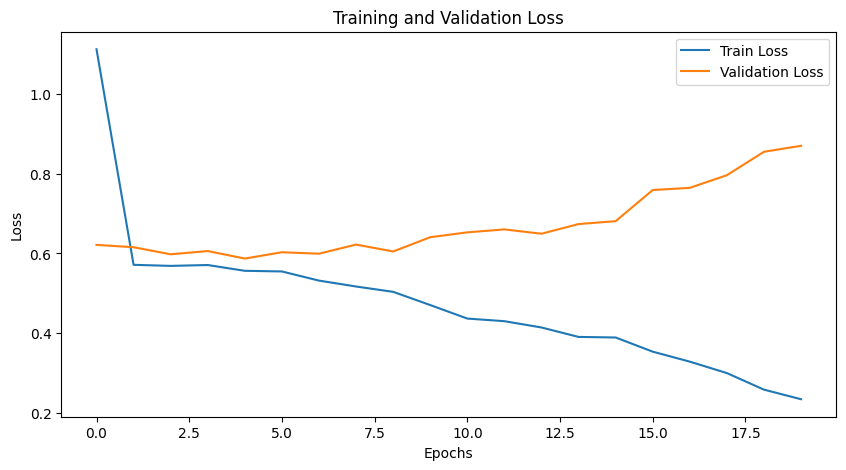

In [ ]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Plot training and validation accuracy and loss
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
Classification Report:
              precision    recall  f1-score   support

     Healthy       0.76      0.78      0.77       121
     Disease       0.25      0.23      0.24        39

    accuracy                           0.64       160
   macro avg       0.50      0.50      0.50       160
weighted avg       0.63      0.64      0.64       160



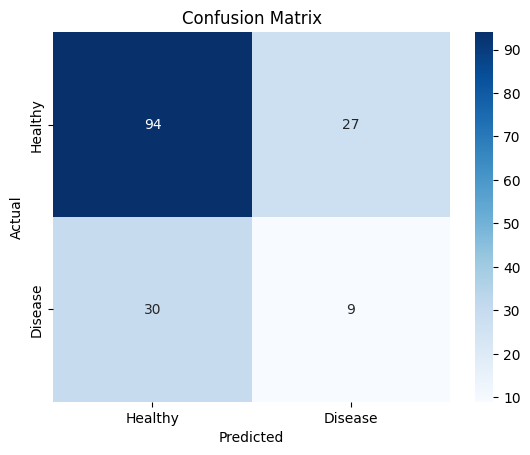

In [ ]:
# Predict on the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Threshold = 0.5

# Evaluate predictions
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Healthy", "Disease"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Disease"], yticklabels=["Healthy", "Disease"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(
    X_train.reshape(X_train.shape[0], -1), y_train
)
X_train_resampled = X_train_resampled.reshape(
    -1, 128, 128, 1
)  # Reshape back to original dimensions


In [ ]:
# Ensure y_train is in integer format
if len(y_train.shape) > 1 and y_train.shape[1] > 1:  # One-hot encoded
    y_train_labels = np.argmax(y_train, axis=1)  # Convert to single-label format
else:
    y_train_labels = y_train  # Already in single-label format

# Compute class weights
class_weights = {
    0: len(y_train_labels) / (2 * np.bincount(y_train_labels)[0]),  # Healthy weight
    1: len(y_train_labels) / (2 * np.bincount(y_train_labels)[1]),  # Disease weight
}

# Fit the model with class weights
history = model.fit(
    X_train,
    y_train,
    class_weight=class_weights,  # Apply computed class weights
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)


Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 879ms/step - accuracy: 0.8504 - loss: 0.5786 - val_accuracy: 0.6250 - val_loss: 0.6940
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8299 - loss: 0.4507 - val_accuracy: 0.5688 - val_loss: 0.7271
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 896ms/step - accuracy: 0.8728 - loss: 0.3665 - val_accuracy: 0.6125 - val_loss: 0.7103
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 891ms/step - accuracy: 0.8919 - loss: 0.3364 - val_accuracy: 0.6500 - val_loss: 0.7090
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 854ms/step - accuracy: 0.9116 - loss: 0.3101 - val_accuracy: 0.6438 - val_loss: 0.7966
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 868ms/step - accuracy: 0.9033 - loss: 0.2561 - val_accuracy: 0.6625 - val_loss: 0.8329
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 938ms/step - accuracy: 0.9204 - loss: 0.2425 - val_accuracy: 0.6187 - val_loss: 0.9352
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 886ms/step - accuracy: 0.9623 - loss: 0.1470 - val_accurac

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
)

datagen.fit(X_train)  # Apply augmentations to the training data


In [ ]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze layers to use as feature extractor

model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')  # Binary classification
])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)


In [ ]:
import numpy as np

# Assuming X_test has shape (160, 128, 128, 1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)  # Repeat the last axis (channel) 3 times

# Now X_test_rgb has shape (160, 128, 128, 3)

In [ ]:
from sklearn.metrics import f1_score

thresholds = np.arange(0.1, 1.0, 0.1)
for t in thresholds:
    y_pred = (model.predict(X_test_rgb) > t).astype("int32") # Use X_test_rgb here
    print(f"Threshold: {t}, F1-Score: {f1_score(y_test, y_pred)}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 39s 8s/step
Threshold: 0.1, F1-Score: 0.39195979899497485
5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 6s/step
Threshold: 0.2, F1-Score: 0.39195979899497485
5/5 ━━━━━━━━━━━━━━━━━━━━ 30s 6s/step
Threshold: 0.30000000000000004, F1-Score: 0.39195979899497485
5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 6s/step
Threshold: 0.4, F1-Score: 0.39195979899497485
5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 6s/step
Threshold: 0.5, F1-Score: 0.3867403314917127
5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step
Threshold: 0.6, F1-Score: 0.25688073394495414
5/5 ━━━━━━━━━━━━━━━━━━━━ 30s 6s/step
Threshold: 0.7000000000000001, F1-Score: 0.047619047619047616
5/5 ━━━━━━━━━━━━━━━━━━━━ 30s 6s/step
Threshold: 0.8, F1-Score: 0.0
5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 7s/step
Threshold: 0.9, F1-Score: 0.0
